## Principal Component Analysis (PCA)

#### **Purpose:**  
#### Reduce the dimensionality of data by finding new orthogonal axes (principal components) that capture the greatest variance.

#### I am gonna explain the key concepts, don't worry.


In [1]:
import random
import math
import matplotlib.pyplot as plt

random.seed(42)

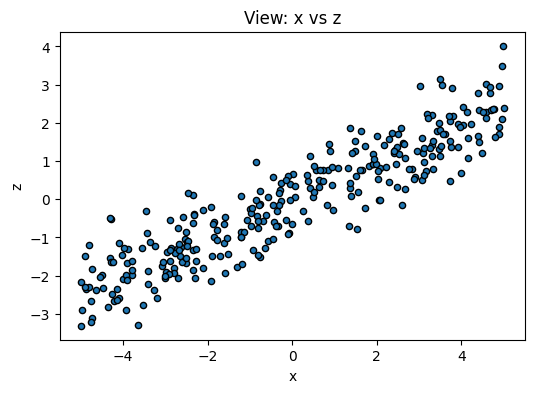

In [2]:
# I am so tired to manually create mini datasets :D
def generate_3d_plane(n=300, noise=0.5):
    data = []
    for _ in range(n):
        x = random.uniform(-5, 5)
        y = random.uniform(-3, 3)
        # z is a linear combination plus noise
        z = 0.5 * x + 0.2 * y + random.gauss(0, noise)
        data.append((x, y, z))
    return data

X = generate_3d_plane()
xs, ys, zs = zip(*X)
plt.figure(figsize=(6,4))
plt.scatter(xs, zs, edgecolors='k', s=20)
plt.title("View: x vs z"); plt.xlabel("x"); plt.ylabel("z")
plt.show()

In [4]:
random.shuffle(X)
split = int(0.8 * len(X))
X_train = X[:split]
X_test  = X[split:]
print(f"Training points: {len(X_train)}, Test points: {len(X_test)}")

Training points: 240, Test points: 60


In [5]:
def mean_vector(points):
    number_of_points = len(points)
    number_of_dimensions = len(points[0])
    
    mean = []
    
    for d in range(number_of_dimensions):
        sum_over_dimension = sum(point[d] for point in points)
        mean_value = sum_over_dimension / number_of_points
        mean.append(mean_value)

    return mean


def covariance_matrix(points):
    number_of_points = len(points)
    number_of_dimensions = len(points[0])

    means = mean_vector(points)

    covariance = [[0.0 for _ in range(number_of_dimensions)] for _ in range(number_of_dimensions)]

    for point in points:
        for i in range(number_of_dimensions):
            for j in range(number_of_dimensions):
                covariance[i][j] += (point[i] - means[i]) * (point[j] - means[j])

    for i in range(number_of_dimensions):
        for j in range(number_of_dimensions):
            covariance[i][j] /= (number_of_points - 1)

    return covariance

#### Now we are implementing power iteration in order to find the top eigenvector

In [6]:
def power_iteration(matrix, tol=1e-6, max_iters=1000):
    dims = len(matrix)
    vector = [random.random() for _ in range(dims)]
    
    norm = math.sqrt(sum(x * x for x in vector))
    vector = [x / norm for x in vector]

    for iteration in range(max_iters):
        
        w = [
            sum(matrix[i][j] * vector[j] for j in range(dims))
            for i in range(dims)
        ]

        lambda_ = sum(w[i] * vector[i] for i in range(dims))

        norm_w = math.sqrt(sum(x * x for x in w))
        next_vector = [x / norm_w for x in w]

        difference = math.sqrt(sum(
            (next_vector[i] - vector[i]) ** 2 for i in range(dims)
        ))

        if difference < tol:
            return lambda_, next_vector

        vector = next_vector

    return lambda_, vector

In [7]:
class PCA:
    def __init__(self, n_components=2, tol=1e-6, max_iters=500):
        self.n_components = n_components
        self.tol = tol
        self.max_iters = max_iters

    def fit(self, points):
        self.mean_ = mean_vector(points)

        centered_data = [
            tuple(point[dim] - self.mean_[dim] for dim in range(len(point)))
            for point in points
        ]

        covariance = covariance_matrix(centered_data)

        self.components_ = []
        self.explained_variance_ = []
        matrix = covariance

        for _ in range(self.n_components):
            lambda_, vector = power_iteration(
                matrix, tol=self.tol, max_iters=self.max_iters
            )
            self.components_.append(vector)
            self.explained_variance_.append(lambda_)

            dims = len(matrix)
            for i in range(dims):
                for j in range(dims):
                    matrix[i][j] -= lambda_ * vector[i] * vector[j]

        return self

    def transform(self, points):
        
        centered_data = [
            tuple(point[dim] - self.mean_[dim] for dim in range(len(point)))
            for point in points
        ]

        projections = []
        for point in centered_data:
            coordinates = [
                sum(point[dim] * component[dim] for dim in range(len(point)))
                for component in self.components_
            ]
            projections.append(tuple(coordinates))

        return projections

    def predict(self, points):
        
        return self.transform(points)

In [8]:
model = PCA(n_components=2)
model.fit(X_train)
print("Mean vector:", model.mean_)
print("Principal components (directions):")
for i, v in enumerate(model.components_, 1):
    print(f" Component {i}:", v)
print("Explained variances:", model.explained_variance_)

Mean vector: [0.033984954856629966, 0.04342160190012276, -0.03803530237197064]
Principal components (directions):
 Component 1: [0.8970984434353098, -0.027548902166508592, 0.4409710203350833]
 Component 2: [-0.060941113815237334, 0.9808000543826279, 0.18524965309007338]
Explained variances: [10.380723948100004, 3.1040054665093253]


In [9]:
def reconstruct(projections, components, mean_vector):
    
    reconstructed = []
    num_dimensions = len(mean_vector)

    for coords in projections:
        
        point_rec = [mean_vector[d] for d in range(num_dimensions)]

        
        for comp_idx, component in enumerate(components):
            for d in range(num_dimensions):
                point_rec[d] += coords[comp_idx] * component[d]

        reconstructed.append(tuple(point_rec))

    return reconstructed


def mean_squared_error(original, reconstructed):
    
    num_points = len(original)
    num_dimensions = len(original[0])

    total_se = 0.0
    for i in range(num_points):
        for d in range(num_dimensions):
            error = original[i][d] - reconstructed[i][d]
            total_se += error ** 2

    return total_se / num_points


def r2_score(original, reconstructed):
    
    num_points = len(original)
    num_dimensions = len(original[0])

    
    global_mean = mean_vector(original)
    tss = 0.0
    for point in original:
        for d in range(num_dimensions):
            diff = point[d] - global_mean[d]
            tss += diff ** 2

    
    rss = 0.0
    for i in range(num_points):
        for d in range(num_dimensions):
            err = original[i][d] - reconstructed[i][d]
            rss += err ** 2

    return 1 - (rss / tss)



train_proj = model.transform(X_train)
test_proj  = model.predict(X_test)

X_train_recon = reconstruct(train_proj, model.components_, model.mean_)
X_test_recon  = reconstruct(test_proj,  model.components_, model.mean_)

print("Train MSE:", round(mean_squared_error(X_train, X_train_recon), 4))
print("Test  MSE:", round(mean_squared_error(X_test,  X_test_recon), 4))
print("Train R²:", round(r2_score(X_train, X_train_recon), 4))
print("Test  R²:", round(r2_score(X_test,  X_test_recon), 4))

Train MSE: 0.1978
Test  MSE: 0.1823
Train R²: 0.9855
Test  R²: 0.9875


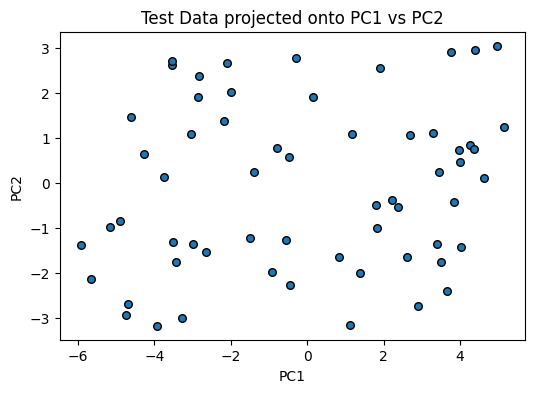

In [10]:
proj2 = model.transform(X_test)
x1, x2 = zip(*proj2)
plt.figure(figsize=(6,4))
plt.scatter(x1, x2, edgecolors='k', s=30)
plt.title("Test Data projected onto PC1 vs PC2")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

### Now What We’ve Understood

#### So, What Is PCA Really?

At its simplest way, I could say that Principal Component Analysis (PCA) is a way to find the “best” directions in your data—those lines or planes along which your points spread out the most. Picture a cloud of data points in space: PCA first finds the single line that captures the largest chunk of that scatter, then finds a second, right‑angled line that captures the next biggest chunk, and so on. By doing this, you can represent your original high‑dimensional data in a much lower number of dimensions, while still keeping as much information as possible.


#### The Main Ideas, Step by Step

**Centre Your Cloud**  
* Before anything else, we subtract the mean of each feature so that the entire cloud of points sits neatly at the origin (0,0,…). If you skip this, your principal directions will simply point toward the “centre of mass” of the data rather than the true directions where the data fans out.

**Measure Joint Variability**  
* We hand‑craft the covariance matrix, a square table where each entry describes how two features vary together.  
   - Diagonal entries (feature with itself) measure the variance of each feature.  
   - Off‑diagonals measure how pairs of features co‑vary.  
   Large values here signal that these features share important patterns of movement, and PCA uses these to identify the best axes.

**Extract the Strongest Directions (Power Iteration)**  
* Instead of relying on a black‑box function, we use power iteration to find the top eigenvector of the covariance matrix. This is arguably the trickiest part of the code:  
   - We start with a random guess vector.  
   - Multiply it by the covariance matrix to “nudge” it in the direction of greatest variance.  
   - Normalise the result (so it doesn’t blow up) and repeat.  
   - Over successive multiplications, this vector converges to the principal direction—mathematically, the eigenvector associated with the largest eigenvalue.  
   The eigenvalue itself quantifies exactly how much variance lies along that direction.

**Peel Off Layers (Deflation)**  
* Once we’ve locked onto the first principal component, we deflate the covariance matrix by subtracting the contribution of that component. This forces the next round of power iteration to find a new direction that is orthogonal (at right angles) to all previously found components. We repeat this until we have as many components as we specified.

**Project and Reconstruct**  
   - **Projection:** We take each centred data point and compute its dot‑products with the principal components. This gives us a new set of coordinates in the reduced space.  
   - **Reconstruction:** By reversing the process—adding back the mean and summing each component times its coordinate—we rebuild an approximation of the original point.  
   Computing Mean Squared Error (MSE) and R² between the original and reconstructed points tells us how much information we lost by reducing dimensions.

**Visualise the Result**  
* Finally, plotting the test data along the first two principal components shows a clear, flattened view of the original 3D plane. You’ll notice there are no artificial clusters—just the continuous spread you’d expect if the data really lay on a 2D surface.

#### The Trickiest Parts of the Code

Covariance Computation
* We manually loop over every point and every pair of dimensions, summing the product of centred values. This double loop can feel slow or unwieldy compared to calling `np.cov`, but it makes the maths crystal‑clear.

Power Iteration
* Turning a random vector into an eigenvector is all about repeated matrix–vector multiplications and normalisations. The key is watching for convergence: when the vector stops changing beyond a tiny threshold, you know you’ve found your principal direction.

Matrix Deflation
* After finding one component, we subtract its share of variance from the covariance matrix. Code‑wise, this is a nested loop updating every entry of the matrix—a straightforward translation of the formula, but easy to get wrong if you miss the signs or scaling.

Reconstruction and R²
* Computing R² without libraries involves carefully calculating total variance and residual sums of squares by hand. Getting the denominators right—using N−1 for covariance, N for MSE—matters for a fair performance measure.

Bottom Line
* By building PCA from scratch—centring data, crafting the covariance, pulling out eigenvectors via power iteration, deflating matrices and reconstructing points—you’ve demystified every step of the algorithm. You now know why each piece is needed, how it works under the hood, and where you might plug in optimisations or extensions for larger, more complex datasets.
